# Overview

This notebook provides support for an article at Medium.com.

Initial concepts over at [ComparisonGroupScratchSpace.ipynb](ComparisonGroupScratchSpace).

In [1]:
import pandas as pd
import numpy as np

from math import sqrt
from scipy.spatial import distance
from scipy.stats import zscore

from pandas_profiling import ProfileReport
import seaborn as sns

sns.set_context("talk")

# Get & Prepare Data

In [2]:
# Use data from US Department of Education IPEDS Surveys
# This data prepared by: https://github.com/adamrossnelson/StataIPEDSAll
location = r'~/documents/ipeds_data/'
dir_info = pd.read_stata(location + 'IPEDSDirInfo02to18.dta')
inst_chs = pd.read_stata(location + 'IPEDSInstChar02to18.dta')

In [3]:
dir_info_17 = dir_info[dir_info['isYr'] == 2017].copy()
inst_chs_17 = inst_chs[inst_chs['isYr'] == 2017].copy()

del dir_info_17['isYr']
del inst_chs_17['isYr']

In [4]:
df = pd.merge(dir_info_17, inst_chs_17, on='unitid')

In [5]:
# Keep a subset of variables only.
# Original dictionary files: 
#   https://nces.ed.gov/ipeds/datacenter/data/HD2017_Dict.zip
#   https://nces.ed.gov/ipeds/datacenter/data/IC2017_Dict.zip
# 
#  unitid   : Unique identificaiotn number.
#  instnm   : Institution name.
#  stabbr   : Institution state abbreviation.
#  sector   : Sector (public, private, 2yr, 4yr, etc.)
#  iclevel  : Two-years, four-yeasr, etc.
#  control  : Public or private institution status.
#  locale   : Urbanicity index.
#  instcat  : Degree-granting category.
#  c15basic : Carnegie classification.
#  instsize : Categorical institution size.
#  longitud : Geographic longidue location.
#  latitude : Geographic latitude location.
#  roomcap  : Residence hall room capacity.
#  roomamt  : Residence hall room fees.
#  boardamt : Dining hall fees.
#  rmbrdamt : Room & bard amount combined (if no roomamt or bardamt)
#  applfeeu : Application fees.
#  applcn   : Count of undergraduate applications.
#  admssn   : Count of undergraduate admissions.
#  enrlft   : Count of full-time enrollment.
#  enrlt    : Count of enrollment.
#  alloncam : Indicates if any students req to live on campus.

df = df[['unitid','instnm','stabbr','sector','iclevel',
         'control','locale','instcat','c15basic','instsize',
         'longitud','latitude','roomcap','roomamt','boardamt',
         'rmbrdamt','applfeeu','applcn','admssn','enrlft',
         'enrlt','alloncam']]

# Define a selectivity index as number of admissions over
# the number of applications. Admission rate.
df['accept'] = df['admssn'] / df['applcn']

# Define a 'residentiality' index as number of on-campus rooms 
# over the number of full-time enrollment.
df['yield'] = df['enrlt'] / df['admssn']

# Setting the unitid as the data frame index.
df.set_index('unitid', inplace=True)

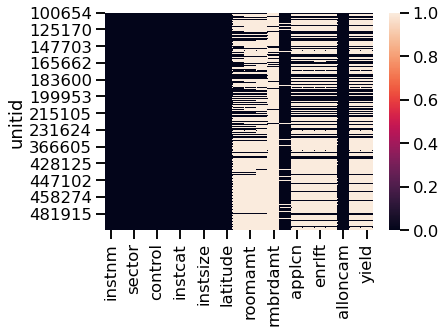

In [6]:
sns.heatmap(df.isna())

In [7]:
# Limit the analysis to public & private 4 year institutions
print('Count of observations before removal : {}.'.format(len(df)))
df = df[(df['sector'] == 'Public, 4-year or above') | \
        (df['sector'] == 'Private not-for-profit, 4-year or above')]
print('Count of observations after removal  : {}.'.format(len(df)))

# Limit the analysis to schools with a residence hall capacity.
print('Count of observations before removal : {}.'.format(len(df)))
df = df[df['roomcap'].fillna(-9999) != -9999]
print('Count of observations after removal  : {}.'.format(len(df)))

# Limit the analysis to schools that report application data.
print('Count of observations before removal : {}.'.format(len(df)))
df = df[df['applcn'].fillna(-9999) != -9999]
print('Count of observations after removal  : {}.'.format(len(df)))

Count of observations before removal : 6882.
Count of observations after removal  : 2453.
Count of observations before removal : 2453.
Count of observations after removal  : 1811.
Count of observations before removal : 1811.
Count of observations after removal  : 1544.


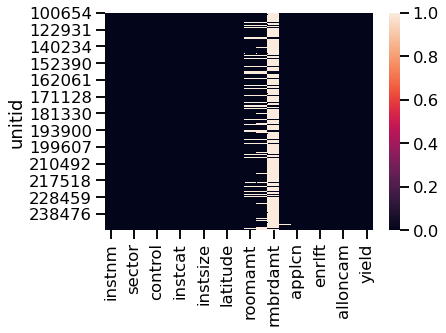

In [8]:
sns.heatmap(df.isna())

In [9]:
df[['roomamt','boardamt']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
roomamt,1238.0,6082.14378,2171.780094,0.0,4600.0,5900.0,7354.5,16675.0
boardamt,1170.0,4597.68547,1193.423839,0.0,3830.0,4581.5,5340.0,8965.0


In [10]:
# Some institutions (n=431) will report combined room & board.
# Estimate room amount as 60% of combined amount.
# Estimate board amount as 40% of combined amount.
df['roomamtX'] = [y * .6 if x == -99 else x for x, y in \
                  zip(df['roomamt'].fillna(-99), df['rmbrdamt'])]
df['boardamtX'] = [y * .4 if x == -99 else x for x, y in \
                   zip(df['boardamt'].fillna(-99), df['rmbrdamt'])]
# Replace missing application fee as zero? Free to apply?
df['applfeeu'].fillna(0, inplace=True)

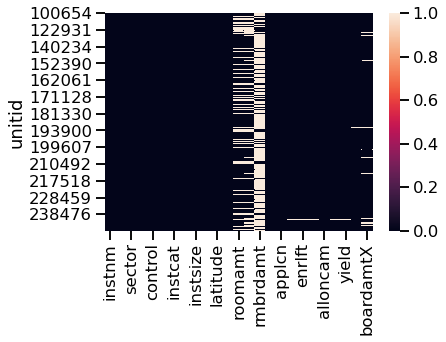

In [11]:
sns.heatmap(df.isna())

In [12]:
df[df['boardamtX'].fillna(-9999) == -9999][['instnm','sector','admssn','rmbrdamt',
                                            'roomamt','roomamtX','boardamt','boardamtX']]

,instnm,sector,admssn,rmbrdamt,roomamt,roomamtX,boardamt,boardamtX
unitid,,,,,,,,
110370,California College of the Arts,"Private not-for-profit, 4-year or above",1277.0,NaN,9840.0,9840.0,NaN,NaN
110547,California State University-Dominguez Hills,"Public, 4-year or above",9333.0,NaN,9012.0,9012.0,NaN,NaN
110918,California Christian College,"Private not-for-profit, 4-year or above",3.0,NaN,4950.0,4950.0,NaN,NaN
117168,Laguna College of Art and Design,"Private not-for-profit, 4-year or above",259.0,NaN,9700.0,9700.0,NaN,NaN
123280,Shasta Bible College and Graduate School,"Private not-for-profit, 4-year or above",7.0,NaN,2400.0,2400.0,NaN,NaN
...,...,...,...,...,...,...,...,...
462354,John Paul the Great Catholic University,"Private not-for-profit, 4-year or above",191.0,NaN,7650.0,7650.0,NaN,NaN
484844,Minerva Schools at Keck Graduate Institute,"Private not-for-profit, 4-year or above",382.0,NaN,10000.0,10000.0,NaN,NaN
486053,Bethlehem College & Seminary,"Private not-for-profit, 4-year or above",27.0,NaN,3400.0,3400.0,NaN,NaN


In [13]:
# 70 Institutions report a room amount but no board amount.
# Change room amount to 60% of reported roomamt.
df['roomamtX'].fillna(df['roomamt'] * .6, inplace=True)
# Enter board amount as 40% of room amount
df['boardamtX'].fillna(df['roomamt'] * .4, inplace=True)

In [14]:
# Check results, display remaining obs with missing data.
df[df['boardamtX'].fillna(-9999) == -9999][['instnm','sector','admssn','rmbrdamt',
                                            'roomamt','roomamtX','boardamt','boardamtX']]

,instnm,sector,admssn,rmbrdamt,roomamt,roomamtX,boardamt,boardamtX
unitid,,,,,,,,
149329,Telshe Yeshiva-Chicago,"Private not-for-profit, 4-year or above",19.0,NaN,NaN,NaN,NaN,NaN
192624,Machzikei Hadath Rabbinical College,"Private not-for-profit, 4-year or above",54.0,NaN,NaN,NaN,NaN,NaN


In [15]:
# Display remaining observations with missing admission fee information
df[df['admssn'].fillna(-9999) == -9999][['instnm','applfeeu','admssn',
                                         'enrlft','enrlt','accept']]

,instnm,applfeeu,admssn,enrlft,enrlt,accept
unitid,,,,,,
142957,American Islamic College,25.0,NaN,NaN,NaN,NaN
245777,Bais Medrash Elyon,0.0,NaN,NaN,NaN,NaN
441609,Yeshiva Shaarei Torah of Rockland,100.0,NaN,NaN,NaN,NaN


In [16]:
len(df)

1544

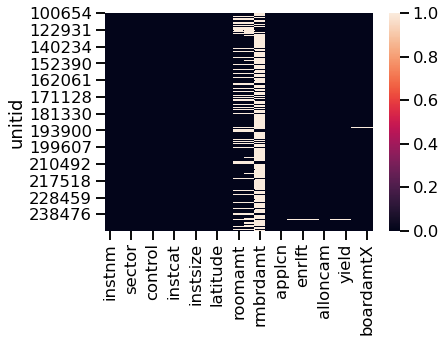

In [17]:
sns.heatmap(df.isna())

In [18]:
# Drop original columns
del df['roomamt']
del df['boardamt']
del df['rmbrdamt']
# Drop these five observations.
df.dropna(inplace=True)

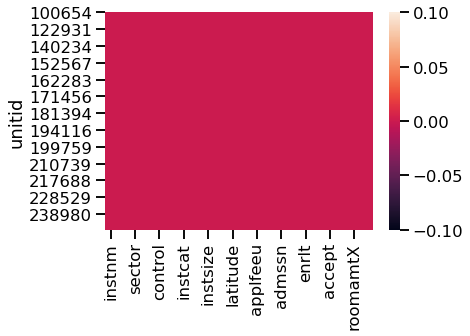

In [19]:
sns.heatmap(df.isna())

In [20]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [21]:
profile.to_file("ipeds_data_sample_2017_report.html")

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
df.head()

,instnm,stabbr,sector,iclevel,control,locale,instcat,c15basic,instsize,longitud,...,applfeeu,applcn,admssn,enrlft,enrlt,alloncam,accept,yield,roomamtX,boardamtX
unitid,,,,,,,,,,,,,,,,,,,,,
100654,Alabama A & M University,AL,"Public, 4-year or above",Four or more years,Public,City: Midsize,"Degree-granting, primarily baccalaureate or above",Master^s Colleges & Universities: Larger Programs,"5,000 - 9,999",-86.568504,...,30.0,8610.0,7772.0,1288.0,1294.0,2. No,0.902671,0.166495,5400.0,3620.0
100663,University of Alabama at Birmingham,AL,"Public, 4-year or above",Four or more years,Public,City: Midsize,"Degree-granting, primarily baccalaureate or above",Doctoral Universities: Highest Research Activity,"20,000 and above",-86.799347,...,30.0,7555.0,6936.0,2228.0,2299.0,2. No,0.918068,0.331459,7532.0,4150.0
100706,University of Alabama in Huntsville,AL,"Public, 4-year or above",Four or more years,Public,City: Midsize,"Degree-granting, primarily baccalaureate or above",Doctoral Universities: Higher Research Activity,"5,000 - 9,999",-86.640450,...,30.0,4454.0,3618.0,1341.0,1352.0,2. No,0.812304,0.373687,5848.8,3899.2
100724,Alabama State University,AL,"Public, 4-year or above",Four or more years,Public,City: Midsize,"Degree-granting, primarily baccalaureate or above",Master^s Colleges & Universities: Medium Programs,"1,000 - 4,999",-86.295677,...,25.0,6842.0,6696.0,951.0,967.0,2. No,0.978661,0.144415,3346.0,2076.0
100751,The University of Alabama,AL,"Public, 4-year or above",Four or more years,Public,City: Small,"Degree-granting, primarily baccalaureate or above",Doctoral Universities: Higher Research Activity,"20,000 and above",-87.545975,...,40.0,38129.0,20321.0,7385.0,7407.0,2. No,0.532954,0.364500,5750.0,3674.0


## Define Functions

In [23]:
def jaccard(data, ref, cols, verbose=False):
    '''Calculates Jarcard index for all observations
    relative to the referenced observation. Returns a list
    of Jaccardian distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''

    try:
        ref_observation = data[cols].iloc[ref]
    except IndexError:
        ref_observation = data[cols].loc[ref]
        ref = df.index.get_loc(ref)
    
    distances = []
    length = len(cols) 
        
    for row in range(len(data)):
        comp_observation = data[cols].iloc[row]
        matches = sum([1 if x == y else 0 for x, y in zip(ref_observation,
                                                          comp_observation)])
        distances.append(1 - (matches / length))
    
    if verbose:
        print('Returning {} distances.'.format(len(distances)))
        print('Minimum distance = 0 : {}'.format(min(distances) == 0))
        print('Maximum distance = {}'.format(max(distances)))
        print('Mean distance = {}'.format(sum(distances) / len(distances)))
        
    return(distances)

# Goal: Count the number of matching dimensions among two observations
def hamming(data, ref, cols):
    '''Calculates Hamming distance for all observations
    relative to the referenced observation. Returns a list
    of hamming distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''

    try:
        ref_observation = data[cols].iloc[ref]
    except IndexError:
        ref_observation = data[cols].loc[ref] 
        ref = df.index.get_loc(ref)

    distances = []
    ref_observation = data[cols].iloc[ref]
    for row in range(len(data)):
        comp_observation = data[cols].iloc[row]
        matches = sum([1 if x == y else 0 for x, y in zip(comp_observation,
                                                          ref_observation)])
        distances.append(matches)
    return(distances)

def euclidian(data, ref, cols, verbose=False):
    '''Calculates Euclidian distance for all observations
    relative to the referenced observation. Returns a list
    of euclidian distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''
        
    try:
        ref_observation = data[cols].apply(zscore).iloc[ref]
    except IndexError:
        ref_observation = data[cols].apply(zscore).loc[ref] 
        ref = df.index.get_loc(ref)
    
    distances = []
    for row in range(len(data)):
        comp_observation = data[cols].apply(zscore).iloc[row]
        dist = distance.euclidean(ref_observation, comp_observation)
        distances.append(dist)
        
    if verbose:
        print('Returning {} distances.'.format(len(distances)))
        print('Minimum distance = 0 : {}'.format(min(distances) == 0))
        print('Maximum distance = {}'.format(max(distances)))
        print('Mean distance = {}'.format(sum(distances) / len(distances)))
    
    return(distances)

# Case Sudies

## University of "Wiscesota"

In [24]:
wiscesota = {'instnm': ['University of Wiscesota'],
             'stabbr': ['IA'],
             'sector': ['Public, 4-year or above'],
             'iclevel': ['Four or more years'],
             'control': ['Public'],
             'locale': ['City: Large'],
             'instcat': ['Degree-granting, primarily baccalaureate or above'],
             'c15basic': ['Doctoral Universities: Highest Research Activity'],
             'instsize': ['20,000 and above'],
             'longitud': [-92.723650],
             'latitude': [42.772996],
             'roomcap': [8998.0],
             'applfeeu': [22.0],
             'applcn': [42596.0],
             'admssn': [18153.0],
             'enrlft': [7597.0],
             'enrlt': [6303.0],
             'alloncam': ['2. No'],
             'accept': [0.42616677622311955],
             'yield': [0.34721533630804824],
             'roomamtX': [6755.0],
             'boardamtX': [4275.0]}

In [25]:
# Append the data frames
df = pd.concat([df, pd.DataFrame(wiscesota)])
# Replace unitid for Wiscesota = 999999
new_index = df.index.to_list()
new_index[-1] = 999999
df.index = new_index

In [26]:
df.loc[999999]

instnm                                 University of Wiscesota
stabbr                                                      IA
sector                                 Public, 4-year or above
iclevel                                     Four or more years
control                                                 Public
locale                                             City: Large
instcat      Degree-granting, primarily baccalaureate or above
c15basic      Doctoral Universities: Highest Research Activity
instsize                                      20,000 and above
longitud                                              -92.7237
latitude                                                42.773
roomcap                                                   8998
applfeeu                                                    22
applcn                                                   42596
admssn                                                   18153
enrlft                                                 

In [27]:
cat_cols = ['stabbr','iclevel','control','locale','c15basic']
df['cat_hams'] = hamming(df, ref=999999,
                         cols=cat_cols)

In [28]:
continous_cols = ['longitud','latitude','roomcap','roomamtX','boardamtX',
                  'accept','yield','cat_hams']
df['wiscesota'] = euclidian(data=df, ref=999999, 
                               cols=continous_cols,
                               verbose=True)

Returning 1540 distances.
Minimum distance = 0 : True
Maximum distance = 18.268786605063784
Mean distance = 6.334483542067474


In [29]:
df.sort_values(by='wiscesota', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['wiscesota']].head(n=10)

,instnm,stabbr,longitud,latitude,roomcap,roomamtX,boardamtX,accept,yield,cat_hams,wiscesota
999999,University of Wiscesota,IA,-92.723650,42.772996,8998.0,6755.0,4275.0,0.426167,0.347215,5,0.000000
240444,University of Wisconsin-Madison,WI,-89.404099,43.075409,8644.0,6225.0,3125.0,0.538066,0.345063,4,1.779092
174066,University of Minnesota-Twin Cities,MN,-93.235466,44.972851,7294.0,5586.0,4266.0,0.496033,0.285866,4,1.791952
215293,University of Pittsburgh-Pittsburgh Campus,PA,-79.953255,40.444389,7831.0,6300.0,4650.0,0.597131,0.243163,4,2.047079
181464,University of Nebraska-Lincoln,NE,-96.700508,40.817596,7200.0,6594.0,4450.0,0.643808,0.509716,4,2.154315
199193,North Carolina State University at Raleigh,NC,-78.674515,35.785110,9556.0,6270.0,4350.0,0.513566,0.346204,4,2.247893
216339,Temple University,PA,-75.156860,39.980545,6003.0,7752.0,3944.0,0.566695,0.254316,4,2.473769
201885,University of Cincinnati-Main Campus,OH,-84.514282,39.131161,6690.0,6624.0,4494.0,0.764924,0.326936,4,2.542562
236948,University of Washington-Seattle Campus,WA,-122.305138,47.655380,9248.0,7270.2,4846.8,0.464224,0.326069,4,2.589941
139755,Georgia Institute of Technology-Main Campus,GA,-84.394829,33.772419,10005.0,6652.0,4840.0,0.233959,0.388248,4,2.622560


In [45]:
print('')
df.head(n=10)[['instnm','applfeeu','cat_hams','wiscesota']].transpose()

,999999,240444,174066,215293,181464,199193,216339,201885,236948,139755
instnm,University of Wiscesota,University of Wisconsin-Madison,University of Minnesota-Twin Cities,University of Pittsburgh-Pittsburgh Campus,University of Nebraska-Lincoln,North Carolina State University at Raleigh,Temple University,University of Cincinnati-Main Campus,University of Washington-Seattle Campus,Georgia Institute of Technology-Main Campus
applfeeu,22,60,55,45,45,85,55,50,70,75
cat_hams,5,4,4,4,4,4,4,4,4,4
wiscesota,0,1.77909,1.79195,2.04708,2.15432,2.24789,2.47377,2.54256,2.58994,2.62256


## University of Wisconsin-Madison

### Euclidian

In [ ]:
# Review Madison's profile based on this data.
df.loc[[240444,174066]]

In [ ]:
continous_cols = ['longitud','latitude','roomcap','roomamtX','boardamtX',
                  'applfeeu','accept','enrlft']
df['WI_euclidian'] = euclidian(data=df, ref=240444, 
                               cols=continous_cols,
                               verbose=True)

In [ ]:
df['WI_euclidian'].hist(bins=100)

In [ ]:
# Verify that Wisconsin is distance zero from itself
print(df.loc[240444]['WI_euclidian'] == 0)
print(df.loc[240444]['WI_euclidian'])

In [ ]:
df.sort_values(by='WI_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['WI_euclidian']].head(n=10)

### Jacardian

In [ ]:
# Define a selectivity index as quitile of accept.
df['selectivity'] = pd.qcut(df['accept'], q=4, labels=['higest selectivity','high selectivity',
                                                       'moderate selectivity','lowest selectivity'])

In [ ]:
# Review Madison's profile based on this data.
df.loc[240444]

In [ ]:
cat_cols = ['stabbr','iclevel','control','locale',
            'c15basic','instsize','selectivity']
df['WI_jacardian'] = jaccard(data=df, ref=240444, 
                             cols=cat_cols,
                             verbose=True)

In [ ]:
df.sort_values(by=['WI_jacardian','WI_euclidian'], inplace=True)
df[['instnm'] + cat_cols + \
   ['WI_euclidian','WI_jacardian']].head(n=15)

## University of North Carolina Charlotte

In [ ]:
df.loc[199139]

In [ ]:
continous_cols = ['longitud','latitude','roomcap','roomamt',
                  'applfeeu','accept','enrlft']
df['CLT_euclidian'] = euclidian(data=df, ref=199139, 
                                cols=continous_cols,
                                verbose=True)

In [ ]:
# Verify that Wisconsin is distance zero from itself
print(df.loc[199139]['CLT_euclidian'] == 0)
print(df.loc[199139]['CLT_euclidian'])

In [ ]:
df.sort_values(by='CLT_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['CLT_euclidian']].head(n=10)

In [ ]:
continous_cols = ['roomcap','roomamt',
                  'applfeeu','accept','enrlft']
df['CLT_euclidian'] = euclidian(data=df, ref=199139, 
                                cols=continous_cols,
                                verbose=True)

In [ ]:
df.sort_values(by='CLT_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['CLT_euclidian']].head(n=10)